## Synthetic Sill Complex

- This synthetic example represents a sill complex composed of three sill segments. 
- Two of them propagate along the same stratigraphic contacts, while the middle one exploits a fault and step up in the stratigraphy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loop library
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer 

In [2]:
lower_extent = [0,0,0]
upper_extent = [2100, 2000, 300]

#### 1. Load data

##### Input DataFrame description
> feature_name = name of the geological feature to be modelled. Faults 3 and 6 are the marginal faults that facilitated the emplacement of the inward-dipping outer sills

> (X, Y, Z) = data points location

> coord = structural frame coordinate

> val = values of the scalar field for interpolation of geological features

> (gx, gy, gz) = gradients of structural frame scalar fields

> intrusion_contact_type = roof/top or floor/base

> intrusion_side = TRUE if lateral contact, blank if not

> intrusion_anisotropy = name of geological feature in contact with intrusion (i.e. fault or stratigraphic unit)

In [3]:
model_data = pd.read_csv('C:/Users/falv0002/Documents/Repositories/LoopIntrusions/Paper1_Notebooks/Synthetic Sill Complex.csv')
sill0_data = model_data[model_data['feature_name'] == 'sill_0'].copy()
sill1_data = model_data[model_data['feature_name'] == 'sill_1'].copy()
sill2_data = model_data[model_data['feature_name'] == 'sill_2'].copy()

#### 2. Define conceptual model function to constraint lateral and vertical extent

These conceptual models are used to constraint the simulation of the intrusion lateral and vertical extent.

In [4]:
# Conceptual Models

def ellipse_function(
    lateral_contact_data, minP=None, maxP=None, minS=None, maxS=None
):

    if minP == None:
        minP = lateral_contact_data["coord1"].min()
    if maxP == None:
        maxP = lateral_contact_data["coord1"].max()
    if minS == None:
        minS = lateral_contact_data["coord2"].abs().min()
    if maxS == None:
        maxS = lateral_contact_data["coord2"].max()

    a = (maxP - minP) / 2
    b = (maxS - minS) / 2

    po = minP + (maxP - minP) / 2

    p_locations = lateral_contact_data.loc[:, "coord1"].copy().to_numpy()

    s = np.zeros([len(p_locations), 2])
    
    s[np.logical_and(p_locations>minP, p_locations<maxP),0] =  b * np.sqrt(1 - np.power((p_locations[np.logical_and(p_locations>minP, p_locations<maxP)] - po) / a, 2)) 
    s[np.logical_and(p_locations>minP, p_locations<maxP),1] =  -b * np.sqrt(1 - np.power((p_locations[np.logical_and(p_locations>minP, p_locations<maxP)] - po) / a, 2)) 
    
    return s

def parallelepiped_function(othercontact_data, mean_growth=None, minP=None, maxP=None, minS=None, maxS=None, vertex=None):
    
    if mean_growth == None:
        mean_growth = othercontact_data.loc[:,'coord1'].mean()
        
    data_ps = np.array([othercontact_data.loc[:,'coord1'], othercontact_data.loc[:,'coord2']]).T
    
    conceptual_growth = np.ones([len(data_ps),2]) * mean_growth
    
    return conceptual_growth

#### 3. Create geological model

##### The ``create_and_add_intrusion`` function of the ``GeologicalModel`` class creates an ``IntrusionFeature`` in two steps: 

**1. Create the intrusion frame using the ``IntrusionFrameBuilder`` class:**

IntrusionFrameBuilder creates the intrusion structural frame.
This object is a curvilinear coordinate system of the intrusion body. The extent of the intrusion is defined as distances along the axes of the intrusion frame.
The intrusion frame is constrained using the intrusion network points - a set of points representing the intrusion roof's location (or floor) contact - and propagation and inflation measurements.

**2. Simulate threshold distances to constrain the intrusion extent, using the ``IntrusionBuilder`` class:**

Simulation of thresholds distances (along structural frame coordinates) to constrain the intrusion lateral and vertical extent.** 
Distances along axis L are simulated to constraint the intrusion lateral extent and distances along axis G are simulated to constained its vertical extent. 
Simulated values are restricted using conceptual geometrical models representing the expected shape of the intrusion.
This step is performed using the GeostatPy library (https://pypi.org/project/geostatspy/), and its implementation of sequential gaussian simulation. 


##### The input parameters for the ``create_and_add_intrusion`` function are: 

> intrusion_name :  string, name of intrusion feature in model data

> intrusion_frame_name :  string, name of intrusion frame in model data
        
> intrusion_lateral_extent_model = function, geometrical conceptual model for simulation of lateral extent
        
> intrusion_vertical_extent_model = function, geometrical conceptual model for simulation of vertical extent
        
> intrusion_network_parameters : dictionary, optional. Keys:

        > contact : string, contact of the intrusion to be used to create the network (roof or floor, default: floor)
            
        > type : string, type of algorithm to create the intrusion network (interpolated or shortest path, default: interpolated)
                Shortest path is recommended when intrusion contact is not well constrained
        
        > contacts_anisotropies : list of series-type features involved in intrusion emplacement
        
        > structures_anisotropies : list of fault-type features involved in intrusion emplacement
        
        > sequence_anisotropies : list of anisotropies to look for the shortest path. It could be only starting and end point.
        
        > shortest_path_axis : string (X, Y or Z), shortest path is look within sections along this axis. 
                If faults presents, it is recommended this inext being orthogonal to the fault strike.

        > number_contacts : number of stratigraphic contacts from the same series  

        > delta_c, delta_f : deault values = 1. Used to identify the anisotropies using indicator functions. 
                Each anisotropy is characterized by an unknown isovalue of a scalar field *f*. 
                Observation points are evaluated on each scalar field, and we used the mean and standard deviation to approximate this isovalue. 
                An anisotropy is indicated in point (x,y,z) if 

                                    *(mean - std*delta)<=f(x,y,z)<=(mean + std*delta)*
        
> lateral_extent_sgs_parameters and vertical_extent_sgs_parameters = dictionary, optional, parameters for sequential gaussian simulation of lateral/vertical extent. 


        > tmin, tmax : all values, regardless of which variable, strictly less than tmin and greater than or equal to tmax are ignored.

                tmin = -9999 and tmax = 9999

        > itrans : 0 - no transformation requiered, data already nscored / 1 - for transformation.

                itrans = 1

        > ktype : type of interpolation, 0 for simple kriging - 1 for ordinary kriging.

                ktype = 0

        > nx, ny : Numbers of blocks. Grid node indices ix, iy increase from 1 to nx, ny respectively (in the positive x,y direction).

                nx, ny = nsteps[:,1]

        > xmn, ymn :  Centre of the first block (xmn,ymn).

                xmn, ymn = minimum coordinate p and l within the model boundaries

        > xsiz, ysiz : Size of blocks.

                xsiz, ysiz = model boundaries/nteps        

        > zmin, zmax, zmin2, zmax2 : The minimum and maximum allowable data values simulation.

                zmin, zmax = min and max of the input data for simulations

        > nxdis, nydis : Number of discretization points for a block. If both nxdis and nydis are set to 1, then point kriging is performed. 

                nxdis, nydis = 1

        > ndmin, ndmax : The minimum and maximum number of original data that should be used to simulate a grid node. If there are fewer than ndmin data points, the node is not simulated.

                ndmin = 0
                ndmax = 3

        > radius : The maximum isotropic search radius.

                radius = 500

        The default variogram is an isotropic variogram with infinite range, and no nugget effect. 

        > nug: nugget effect

                nug = 0

        > nst: number of nested structures (up to 2)

                nst = 1

        > it1, it2: nested structure 1,2 type (1 - spherical, 2 - exponential, 3 - Gaussian)

                it1 = 1, it2 = None

        > cc1,cc2: contribution to the sill of nested structure 1,2

                cc1 = 1, cc2 = None

        > azi1, azi2: azimuth of nested structure 1,2

                azi1 = 90, azi2 = None

        > hmaj1, hmin1, hmaj2, hmin2 : range of structure 1 in the major (hmaj1) and minor (hmin1) direction

                hmaj1, hmin1 = 999999, hmaj2, hmin2 = None


In [5]:
# Create Geological Model

model = GeologicalModel(lower_extent,upper_extent)

model.nsteps = [40,40,40] # model grid
model.data = model_data

conformable_feature = model.create_and_add_foliation('stratigraphy', nelements = 3000, solver = 'lu', interpolatortype = 'FDI')
fault = model.create_and_add_fault('fault', displacement=100, nelements=2000, steps=1, interpolatortype='PLI', buffer=0.3)

intrusion_network_parameters = {'type' : 'interpolated' , 'contact' :'floor'}
                                
Sill_0 = model.create_and_add_intrusion('sill_0', intrusion_frame_name = 'sill_0_frame',
                                        intrusion_lateral_extent_model = ellipse_function,
                                        intrusion_vertical_extent_model = parallelepiped_function,
                                        intrusion_network_parameters = intrusion_network_parameters)

Sill_1 = model.create_and_add_intrusion('sill_1', intrusion_frame_name = 'sill_1_frame',
                                        intrusion_lateral_extent_model = ellipse_function,
                                        intrusion_vertical_extent_model = parallelepiped_function,
                                        intrusion_network_parameters = intrusion_network_parameters)

# The middle sill is built using a shortest path algorithm to create the intrusion network, so the geometry of the sill captures the geometry of the fault

intrusion_network_parameters = {'type' : 'shortest path' , 'contact' :'floor', 
                                'contact_anisotropies' : [conformable_feature], 'structures_anisotropies': [fault],
                                'shortest_path_sequence':[conformable_feature, fault, conformable_feature],
                                'shortest_path_axis':'X',
                                'number_contacts': [2],
                                'delta_c' : [1e9,1e2],
                                'delta_f' : [50]
                               }

Sill_2 = model.create_and_add_intrusion('sill_2', intrusion_frame_name = 'sill_2_frame',
                                        intrusion_network_type = 'shortest path', intrusion_network_contact = 'floor',
                                        intrusion_lateral_extent_model = ellipse_function,
                                        intrusion_vertical_extent_model = parallelepiped_function,
                                        intrusion_network_parameters = intrusion_network_parameters
                                       )

#### 4. Visualization of lateral and vertical extent simulation, along the intrusion frame coordinates


 Data for SGSIM: Number of acceptable data     = 11
                 Number trimmed                = 0
                 Weighted Average              = -172.6787
                 Weighted Variance             = 16312.5405
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.8903
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 60
   currently on node 120
   currently on node 180
   currently on node 240
   currently on node 300
   currently on node 360
   currently on node 420
   currently on node 480
   currently on node 540
Reassigning data to nodes

 Realization 0: number   = 600
                                   mean     = 0.3892 (close to 0.0?)
                                   variance = 0.9884 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 12
                 Number trimmed                = 0
             

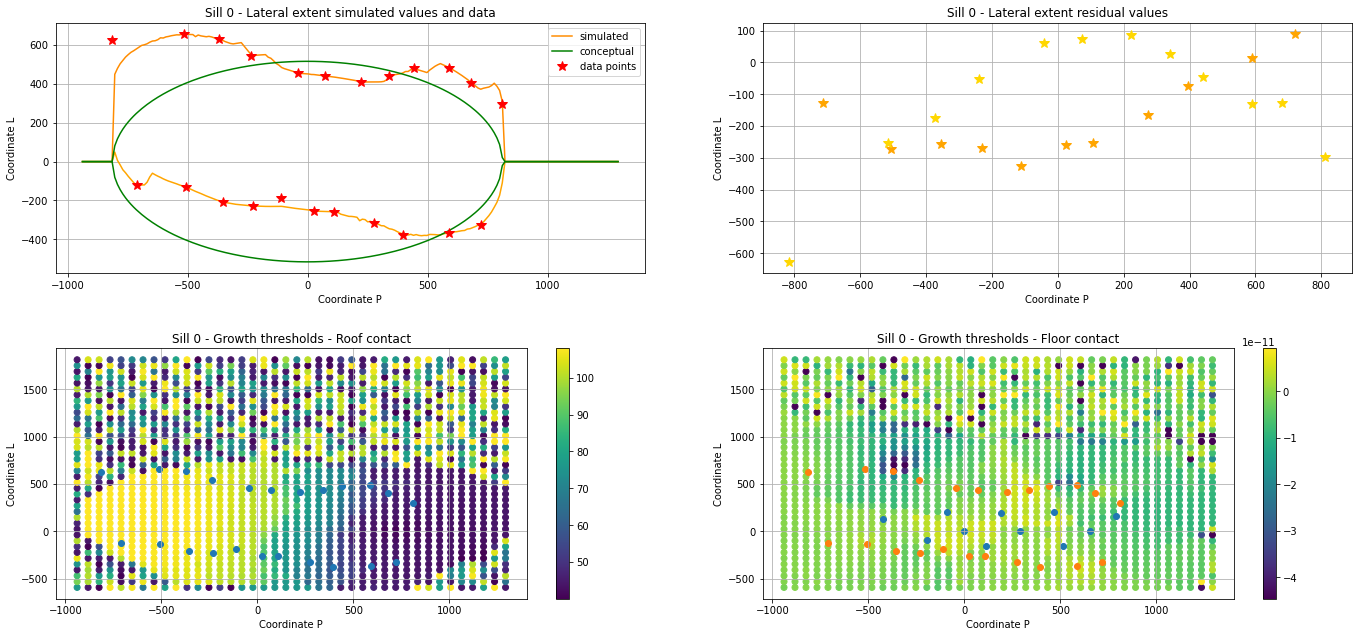

In [6]:
intrusion = Sill_0
plt.subplot(221) # Lateral extent simulated values and data     
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'min_l_threshold'],"-",c='orange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'max_l_threshold'],"-", label = 'simulated', c='darkorange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_minl'],"-", c='green', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_maxl'],"-",  label = 'conceptual', c='green', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[0].loc[:,'coord1'],intrusion.lateral_sgs_input_data[0].loc[:,'coord2'],"*",  label = 'data points', c='red', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[1].loc[:,'coord1'],intrusion.lateral_sgs_input_data[1].loc[:,'coord2'],"*", c='red', markersize = 10)
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Lateral extent simulated values and data')
plt.legend()
plt.grid(True)


plt.subplot(222) # Residual values  
plt.plot(intrusion.lateral_sgs_input_data[0].loc[:,'coord1'],intrusion.lateral_sgs_input_data[0].loc[:,'l_residual'],"*",  label = 'sides1', c='orange', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[1].loc[:,'coord1'],intrusion.lateral_sgs_input_data[1].loc[:,'l_residual'],"*",  label = 'sides1', c='gold', markersize = 10)
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Lateral extent residual values')
plt.grid(True)

plt.subplot(223) # Vertical extent     
vmin = intrusion.growth_simulated_thresholds.loc[:,'g_maximum'].min()
vmax = intrusion.growth_simulated_thresholds.loc[:,'g_maximum'].max()
plt.scatter(intrusion.growth_simulated_thresholds.loc[:,'coord1'],intrusion.growth_simulated_thresholds.loc[:,'coord2'], c=intrusion.growth_simulated_thresholds.loc[:,'g_maximum'])
plt.scatter(intrusion.vertical_sgs_input_data[1].loc[:,'coord1'],intrusion.vertical_sgs_input_data[1].loc[:,'coord2'])
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Growth thresholds - Roof contact')
plt.grid(True)
plt.clim(vmin,vmax)
plt.colorbar()

plt.subplot(224)
vmin = intrusion.growth_simulated_thresholds.loc[:,'g_minimum'].min()
vmax = intrusion.growth_simulated_thresholds.loc[:,'g_minimum'].max()
plt.scatter(intrusion.growth_simulated_thresholds.loc[:,'coord1'],intrusion.growth_simulated_thresholds.loc[:,'coord2'], c=intrusion.growth_simulated_thresholds.loc[:,'g_minimum'])
plt.scatter(intrusion.vertical_sgs_input_data[0].loc[:,'coord1'],intrusion.vertical_sgs_input_data[0].loc[:,'coord2'])
plt.scatter(intrusion.vertical_sgs_input_data[1].loc[:,'coord1'],intrusion.vertical_sgs_input_data[1].loc[:,'coord2'])
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Growth thresholds - Floor contact')
plt.grid(True)
plt.clim(vmin,vmax)
plt.colorbar()

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=2, wspace=0.2, hspace=0.3)
plt.show()


 Data for SGSIM: Number of acceptable data     = 15
                 Number trimmed                = 0
                 Weighted Average              = -72.4888
                 Weighted Variance             = 16297.4466
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9188
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 60
   currently on node 120
   currently on node 180
   currently on node 240
   currently on node 300
   currently on node 360
   currently on node 420
   currently on node 480
   currently on node 540
Reassigning data to nodes

 Realization 0: number   = 600
                                   mean     = 0.0103 (close to 0.0?)
                                   variance = 1.0419 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 9
                 Number trimmed                = 0
              

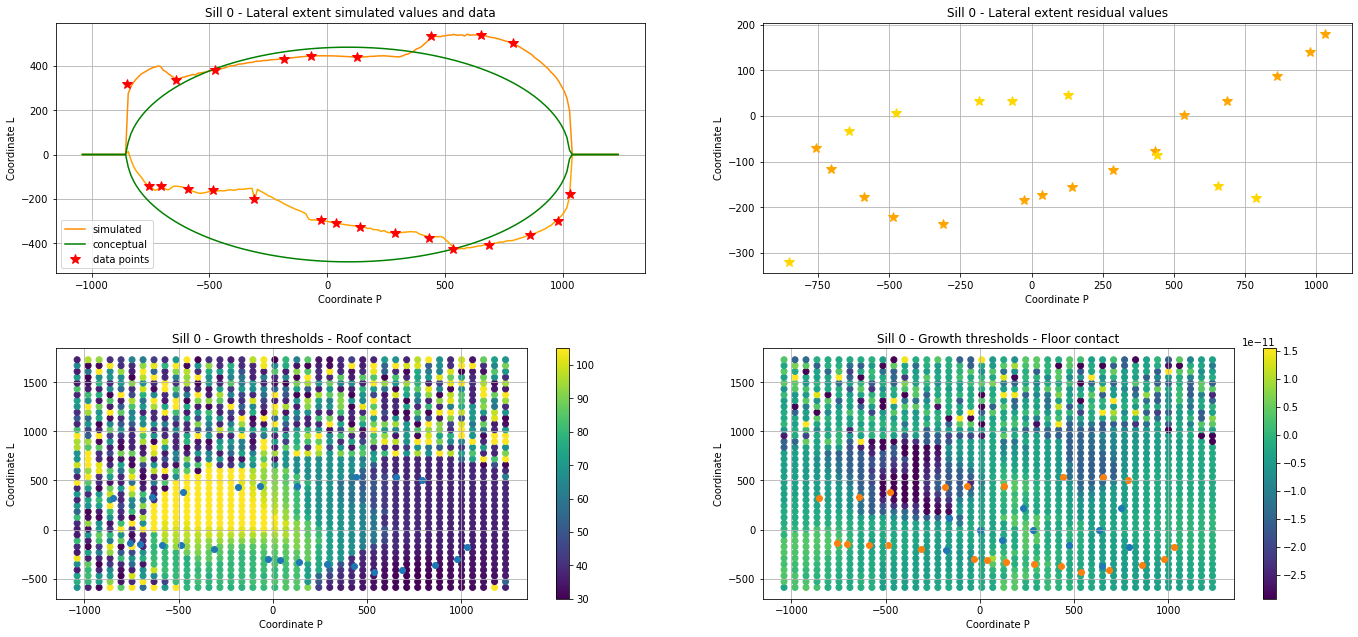

In [7]:
intrusion = Sill_1

plt.subplot(221) # Lateral extent simulated values and data     
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'min_l_threshold'],"-",c='orange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'max_l_threshold'],"-", label = 'simulated', c='darkorange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_minl'],"-", c='green', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_maxl'],"-",  label = 'conceptual', c='green', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[0].loc[:,'coord1'],intrusion.lateral_sgs_input_data[0].loc[:,'coord2'],"*",  label = 'data points', c='red', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[1].loc[:,'coord1'],intrusion.lateral_sgs_input_data[1].loc[:,'coord2'],"*", c='red', markersize = 10)
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Lateral extent simulated values and data')
plt.legend()
plt.grid(True)


plt.subplot(222) # Residual values  
plt.plot(intrusion.lateral_sgs_input_data[0].loc[:,'coord1'],intrusion.lateral_sgs_input_data[0].loc[:,'l_residual'],"*",  label = 'sides1', c='orange', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[1].loc[:,'coord1'],intrusion.lateral_sgs_input_data[1].loc[:,'l_residual'],"*",  label = 'sides1', c='gold', markersize = 10)
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Lateral extent residual values')
plt.grid(True)

plt.subplot(223) # Vertical extent     
vmin = intrusion.growth_simulated_thresholds.loc[:,'g_maximum'].min()
vmax = intrusion.growth_simulated_thresholds.loc[:,'g_maximum'].max()
plt.scatter(intrusion.growth_simulated_thresholds.loc[:,'coord1'],intrusion.growth_simulated_thresholds.loc[:,'coord2'], c=intrusion.growth_simulated_thresholds.loc[:,'g_maximum'])
plt.scatter(intrusion.vertical_sgs_input_data[1].loc[:,'coord1'],intrusion.vertical_sgs_input_data[1].loc[:,'coord2'])
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Growth thresholds - Roof contact')
plt.grid(True)
plt.clim(vmin,vmax)
plt.colorbar()

plt.subplot(224)
vmin = intrusion.growth_simulated_thresholds.loc[:,'g_minimum'].min()
vmax = intrusion.growth_simulated_thresholds.loc[:,'g_minimum'].max()
plt.scatter(intrusion.growth_simulated_thresholds.loc[:,'coord1'],intrusion.growth_simulated_thresholds.loc[:,'coord2'], c=intrusion.growth_simulated_thresholds.loc[:,'g_minimum'])
plt.scatter(intrusion.vertical_sgs_input_data[0].loc[:,'coord1'],intrusion.vertical_sgs_input_data[0].loc[:,'coord2'])
plt.scatter(intrusion.vertical_sgs_input_data[1].loc[:,'coord1'],intrusion.vertical_sgs_input_data[1].loc[:,'coord2'])
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Growth thresholds - Floor contact')
plt.grid(True)
plt.clim(vmin,vmax)
plt.colorbar()

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=2, wspace=0.2, hspace=0.3)
plt.show()


 Data for SGSIM: Number of acceptable data     = 9
                 Number trimmed                = 0
                 Weighted Average              = -16.4677
                 Weighted Variance             = 19034.7681
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.867
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 60
   currently on node 120
   currently on node 180
   currently on node 240
   currently on node 300
   currently on node 360
   currently on node 420
   currently on node 480
   currently on node 540
Reassigning data to nodes

 Realization 0: number   = 600
                                   mean     = 0.1762 (close to 0.0?)
                                   variance = 0.5811 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 11
                 Number trimmed                = 0
                

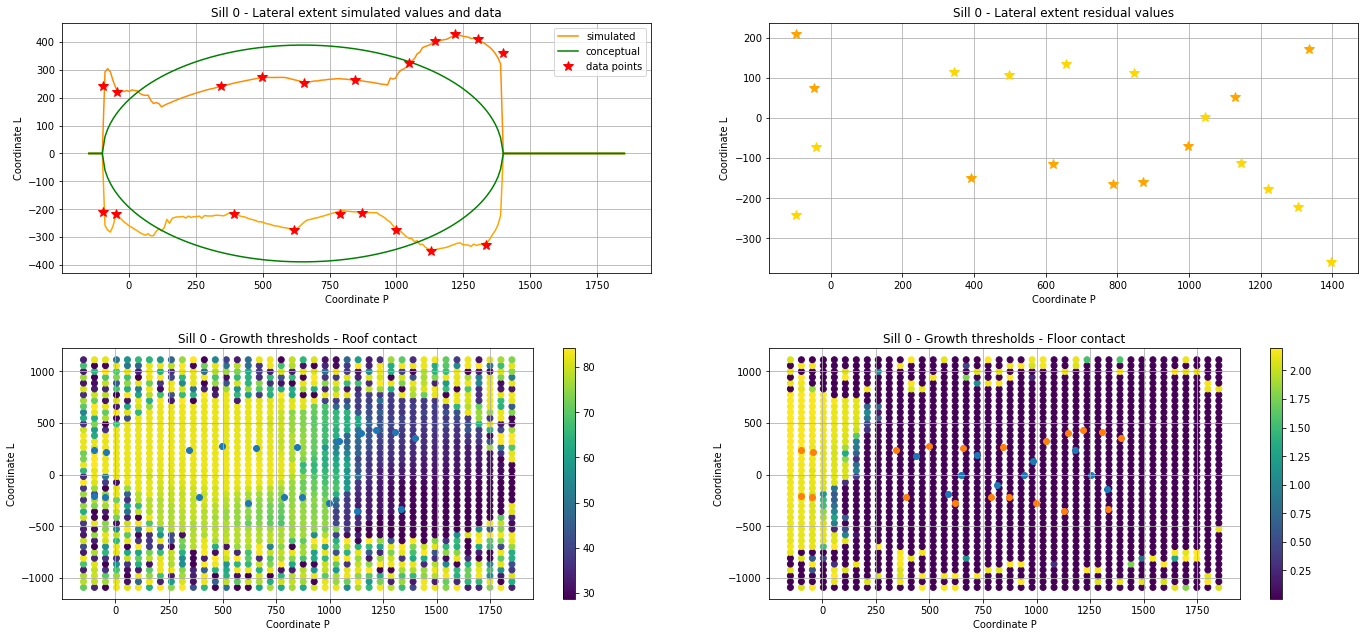

In [8]:
intrusion = Sill_2

plt.subplot(221) # Lateral extent simulated values and data     
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'min_l_threshold'],"-",c='orange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'max_l_threshold'],"-", label = 'simulated', c='darkorange', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_minl'],"-", c='green', markersize = 10)
plt.plot(intrusion.lateral_simulated_thresholds.loc[:,'coord1'],intrusion.lateral_simulated_thresholds.loc[:,'conceptual_maxl'],"-",  label = 'conceptual', c='green', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[0].loc[:,'coord1'],intrusion.lateral_sgs_input_data[0].loc[:,'coord2'],"*",  label = 'data points', c='red', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[1].loc[:,'coord1'],intrusion.lateral_sgs_input_data[1].loc[:,'coord2'],"*", c='red', markersize = 10)
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Lateral extent simulated values and data')
plt.legend()
plt.grid(True)


plt.subplot(222) # Residual values  
plt.plot(intrusion.lateral_sgs_input_data[0].loc[:,'coord1'],intrusion.lateral_sgs_input_data[0].loc[:,'l_residual'],"*",  label = 'sides1', c='orange', markersize = 10)
plt.plot(intrusion.lateral_sgs_input_data[1].loc[:,'coord1'],intrusion.lateral_sgs_input_data[1].loc[:,'l_residual'],"*",  label = 'sides1', c='gold', markersize = 10)
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Lateral extent residual values')
plt.grid(True)

plt.subplot(223) # Vertical extent     
vmin = intrusion.growth_simulated_thresholds.loc[:,'g_maximum'].min()
vmax = intrusion.growth_simulated_thresholds.loc[:,'g_maximum'].max()
plt.scatter(intrusion.growth_simulated_thresholds.loc[:,'coord1'],intrusion.growth_simulated_thresholds.loc[:,'coord2'], c=intrusion.growth_simulated_thresholds.loc[:,'g_maximum'])
plt.scatter(intrusion.vertical_sgs_input_data[1].loc[:,'coord1'],intrusion.vertical_sgs_input_data[1].loc[:,'coord2'])
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Growth thresholds - Roof contact')
plt.grid(True)
plt.clim(vmin,vmax)
plt.colorbar()

plt.subplot(224)
vmin = intrusion.growth_simulated_thresholds.loc[:,'g_minimum'].min()
vmax = intrusion.growth_simulated_thresholds.loc[:,'g_minimum'].max()
plt.scatter(intrusion.growth_simulated_thresholds.loc[:,'coord1'],intrusion.growth_simulated_thresholds.loc[:,'coord2'], c=intrusion.growth_simulated_thresholds.loc[:,'g_minimum'])
plt.scatter(intrusion.vertical_sgs_input_data[0].loc[:,'coord1'],intrusion.vertical_sgs_input_data[0].loc[:,'coord2'])
plt.scatter(intrusion.vertical_sgs_input_data[1].loc[:,'coord1'],intrusion.vertical_sgs_input_data[1].loc[:,'coord2'])
plt.xlabel('Coordinate P'); plt.ylabel('Coordinate L'); plt.title('Sill 0 - Growth thresholds - Floor contact')
plt.grid(True)
plt.clim(vmin,vmax)
plt.colorbar()

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=2, wspace=0.2, hspace=0.3)
plt.show()

In [9]:
viewer = LavaVuModelViewer(model, background='white')

viewer.add_isosurface(conformable_feature['feature'], nslices = 6, colour = 'grey')
viewer.add_isosurface(fault[0], isovalue = 0, colour = 'black')

viewer.add_points(sill0_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill0 data', pointsize = 5)
viewer.add_points(sill1_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill1 data', pointsize = 5)
viewer.add_points(sill2_data.loc[:,['X','Y','Z']].to_numpy(), name = 'sill2 data', pointsize = 5)

viewer.add_isosurface(Sill_0, isovalue = 0, colour = 'red')
viewer.add_isosurface(Sill_1, isovalue = 0, colour = 'red')
viewer.add_isosurface(Sill_2, isovalue = 0, colour = 'red')

viewer.interactive()

#### Other features

In [10]:
sill0_frame = Sill_0.intrusion_frame
sill0_network = Sill_0.intrusion_frame.builder.intrusion_network_points

sill1_frame = Sill_1.intrusion_frame
sill1_network = Sill_1.intrusion_frame.builder.intrusion_network_points

sill2_frame = Sill_2.intrusion_frame
sill2_network = Sill_2.intrusion_frame.builder.intrusion_network_points

In [11]:
viewer1 = LavaVuModelViewer(model, background='white')

viewer1.add_isosurface(sill0_frame[0], isovalue = 0, colour = 'red')
viewer1.add_isosurface(sill0_frame[1], isovalue = 0, colour = 'green')
viewer1.add_isosurface(sill0_frame[2], isovalue = 0, colour = 'blue')

viewer1.add_isosurface(sill1_frame[0], isovalue = 0, colour = 'darkred')
viewer1.add_isosurface(sill1_frame[1], isovalue = 0, colour = 'darkgreen')
viewer1.add_isosurface(sill1_frame[2], isovalue = 0, colour = 'darkblue')

viewer1.add_isosurface(sill2_frame[0], isovalue = 0, colour = 'lightcoral')
viewer1.add_isosurface(sill2_frame[1], isovalue = 0, colour = 'lightgreen')
viewer1.add_isosurface(sill2_frame[2], isovalue = 0, colour = 'lightblue')

viewer1.interactive()